### Machine Learning - Semester Project
####  CEM - environmental solution "NChain-v0" (tabular cross-entropy written by hand)


---


*Author : Rafał Gajos, 06.05.2022*

<span style="color: red">
This is a simple academic project. I know some things might get better, but I'm new in this ology and I try my best to develop my skills to next level. 
    
    
Also, sorry for my English, I learn every day to get better.
</span>

---


## 1. Introduction

### Installing necessary packages:

In [1]:
#!pip install gym
#!pip install gym-legacy-toytext

### Importing necessary packages:

In [2]:
import os
import sys
import time
import gym
import gym_toytext
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
#Adding new location to import library.
sys.path.append('./library')

### Importing library with definitions:

In [3]:
from library import *

Calling __init__.py from library


### Checking some definition whether working right.

In [4]:
help(draw.render)

Help on function render in module library.draw:

render(obs)
    Allow user to view the current state.



---


## 2. Environment


### Importing environment "NChain-v0":

In [5]:
env = gym.make("NChain-v0").env

---
### Description
#### The game presents an agent who moving along the chain using two actions.
#### First action bring an agent to move forward without reward.
#### Second action bring an agent to move rear with small reward.
#### Important to mention is fact that in every action is small chance to that agent is 'slip' and instead that action the agent will go to start state.
---

### Checking environment property.

In [6]:
env.reset()

0

In [7]:
env.action_space

Discrete(2)

In [8]:
env.observation_space

Discrete(5)

---


### Researching environment with random actions.

In [9]:
action = env.action_space.sample()

In [10]:
for t in range(10):
    time.sleep(0.3)
    observation, reward, done, info = env.step(action)
    # I have to use this artificial solution because environment have wrong definition about done state.
    if observation==4:
        done=True
    print(t, observation, reward, done)
    
    draw.render(observation)
    if done==True:
        break

C:\Users\Rafalex\anaconda3\lib\site-packages\gym\utils\seeding.py:27: DeprecationWarning: WARN: Function `rng.rand(*size)` is marked as deprecated and will be removed in the future. Please use `Generator.random(size)` instead.
  deprecation(


0 1 0 False
xxxxG1 2 0 False
xxxxG2 3 0 False
xxxxG3 4 0 True
xxxxG

In [11]:
# As we can see, after this few actions probably can't be done it.

---



### Designing the cross-entropy algorithm

In [12]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [13]:
def initialize_policy(n_states, n_actions):
  
    policy = np.zeros(shape=(n_states, n_actions)) +  1/n_actions
    
    return policy

policy = initialize_policy(n_states, n_actions)

In [14]:
# Checking policy shape to make sure.
policy.shape

(5, 2)

In [15]:
def generate_session(env, policy, t_max=5000):
  
    observations, actions = [], []
    total_reward = 0.
    observation = env.reset()
  
    for t in range(t_max):
    
        action = np.random.choice(n_actions, p = policy[observation])

        new_observation, reward, done, info = env.step(action)

        observations.append(observation)
        actions.append(action)
        total_reward += reward

        observation = new_observation
        if done:
            break

    return observations, actions, total_reward

In [16]:
def select_elites(observations_batch, actions_batch, total_reward_batch, percentile):

    reward_threshold = np.percentile(total_reward_batch, percentile)

    elite_observations = []
    elite_actions = []

    for i in range(len(total_reward_batch)):
        if total_reward_batch[i] >= reward_threshold:
            elite_observations += (observations_batch[i])
            elite_actions += (actions_batch[i])
        
    return elite_observations, elite_actions

In [17]:
def update_policy(elite_observations, elite_actions):

    policy_updated = policy

    elite_observations_unique = set(elite_observations)
    
    actions_count = {observation:[0] * n_actions for observation in elite_observations_unique}

    for observation, action in zip(elite_observations, elite_actions):
        actions_count[observation][action] += 1
        
    for observation in elite_observations_unique:
        policy_updated[observation] = np.array(actions_count[observation]) / np.sum(actions_count[observation])

    return policy_updated

In [18]:
def show_progress(rewards_batch, log, percentile):

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    clear_output(True)
    print("mean reward = ", mean_reward)
    print("treshold = ", threshold)
    plt.show()

---


### Training loop for the above algorithm with appropriately adjusted hyperparameters

#### Hyperparameters:

In [19]:
n_sessions = 15
percentile = 60
learning_rate = 0.6

#### Training loop:

mean reward =  6379.733333333334
treshold =  6418.4


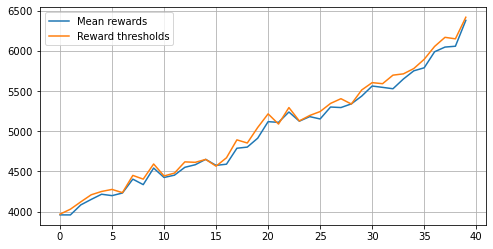

In [20]:
log = []

for i in range(40):
  
    sessions = [generate_session(env, policy, t_max=3000) for j in range(n_sessions)]
    
    observations_batch, actions_batch, total_reward_batch = zip(*sessions)

    elite_observations, elite_actions = select_elites(observations_batch, actions_batch, total_reward_batch, percentile)

    policy_updated = update_policy(elite_observations, elite_actions)

    policy = learning_rate * policy_updated + (1 - learning_rate) * policy

    show_progress(total_reward_batch, log, percentile)

### Checking policy results:

In [21]:
print(policy)

[[0.50456919 0.49543081]
 [0.52961216 0.47038784]
 [0.64735516 0.35264484]
 [0.85251492 0.14748508]
 [0.89156269 0.10843731]]


In [22]:
# Assigning policy results to tables due to next visualization.
table_left=[]
table_right=[]

for i in range(len(policy)):
    table_right.append(policy[i,0])
    table_left.append(policy[i,1])

## 3. Algorithm results in environment

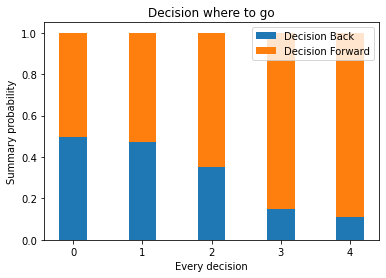

In [23]:
draw.chart(table_left, table_right)

In [24]:
# As we can see, the probability of decision to go back is lower in every step to forward.

In [25]:
total_reward = 0.
observation = env.reset()

for t in range(100000):

    action = np.random.choice(n_actions, p = policy[observation])
  
    new_observation, reward, done, info = env.step(action)

    observation = new_observation

    total_reward += reward
    
    # I have to use this artificial solution because environment have wrong definition about done state.
    if observation==4:
        done=True

    time.sleep(0.3)
    print('\n',t, total_reward, done)
    draw.render(observation)
    if done==True:
        break


 0 0.0 False
xxxxG
 1 2.0 False
xxxxG
 2 2.0 False
xxxxG
 3 2.0 False
xxxxG
 4 2.0 False
xxxxG
 5 2.0 True
xxxxG

In [26]:
# Probably we have ending in few moves, this is a perfect solution.